In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam


In [2]:
# ---------- (a,b) Load data ----------
DATA_PATH = "ecg.csv"
if os.path.exists(DATA_PATH):
    df = pd.read_csv(DATA_PATH).select_dtypes(include=[np.number])
    print("Loaded", DATA_PATH, "shape:", df.shape)
else:
    rng = np.random.RandomState(0)
    df = pd.DataFrame(np.vstack([rng.normal(size=(500,5)),
                                 rng.normal(5,0.5,size=(10,5))]),
                      columns=[f"f{i}" for i in range(5)])
    print("Using generated demo data, shape:", df.shape)

# ---------- Preprocess ----------
X = MinMaxScaler().fit_transform(df.values)
X_train, X_test = train_test_split(X, test_size=0.2, random_state=1)
n_features = X_train.shape[1]


Loaded ecg.csv shape: (4997, 141)


In [3]:
# ---------- (c,d) Encoder → Latent → Decoder ----------
latent_dim = max(1, n_features // 3)
inp = Input(shape=(n_features,))
h = Dense(max(8, latent_dim*4), activation="relu")(inp)
z = Dense(latent_dim, activation="relu", name="latent")(h)
h2 = Dense(max(8, latent_dim*4), activation="relu")(z)
out = Dense(n_features, activation="sigmoid")(h2)

autoencoder = Model(inp, out)
autoencoder.compile(optimizer=Adam(1e-3), loss="mse", metrics=["mae"])

# ---------- Train ----------
autoencoder.fit(X_train, X_train, epochs=10, batch_size=32,
                validation_data=(X_test, X_test), verbose=1)

# ---------- Detect anomalies ----------
X_train_pred = autoencoder.predict(X_train)
X_test_pred  = autoencoder.predict(X_test)
train_err = np.mean((X_train - X_train_pred)**2, axis=1)
test_err  = np.mean((X_test  - X_test_pred)**2, axis=1)

threshold = np.percentile(train_err, 95)
anomaly_mask = test_err > threshold

print(f"Threshold = {threshold:.6f}")
print(f"Detected {anomaly_mask.sum()} anomalies out of {len(test_err)} test samples")


Epoch 1/10
125/125 [==============================] - 2s 7ms/step - loss: 0.0076 - mae: 0.0571 - val_loss: 0.0033 - val_mae: 0.0367
Epoch 2/10
125/125 [==============================] - 1s 5ms/step - loss: 0.0025 - mae: 0.0324 - val_loss: 0.0019 - val_mae: 0.0286
Epoch 3/10
125/125 [==============================] - 1s 5ms/step - loss: 0.0016 - mae: 0.0266 - val_loss: 0.0014 - val_mae: 0.0243
Epoch 4/10
125/125 [==============================] - 1s 5ms/step - loss: 0.0012 - mae: 0.0228 - val_loss: 0.0011 - val_mae: 0.0217
Epoch 5/10
125/125 [==============================] - 1s 7ms/step - loss: 9.4731e-04 - mae: 0.0202 - val_loss: 9.4152e-04 - val_mae: 0.0194
Epoch 6/10
125/125 [==============================] - 1s 7ms/step - loss: 8.0944e-04 - mae: 0.0187 - val_loss: 8.5142e-04 - val_mae: 0.0184
Epoch 7/10
125/125 [==============================] - 1s 6ms/step - loss: 7.2993e-04 - mae: 0.0177 - val_loss: 7.8693e-04 - val_mae: 0.0176
Epoch 8/10
125/125 [==============================] 

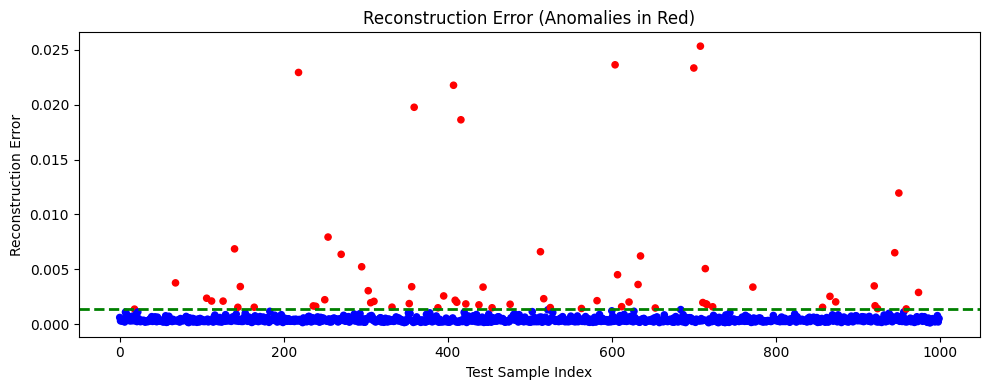

In [4]:
# ---------- Visualization ----------
plt.figure(figsize=(10,4))
plt.scatter(range(len(test_err)), test_err, s=20, c=["red" if a else "blue" for a in anomaly_mask])
plt.axhline(threshold, color='green', linestyle='--', linewidth=2)
plt.title("Reconstruction Error (Anomalies in Red)")
plt.xlabel("Test Sample Index")
plt.ylabel("Reconstruction Error")
plt.tight_layout()
plt.show()

In [5]:
# ---------- Save anomalies ----------
anom_df = pd.DataFrame(X_test, columns=df.columns)
anom_df["reconstruction_error"] = test_err
anom_df["anomaly"] = anomaly_mask.astype(int)
anom_df[anom_df["anomaly"]==1].to_csv("anomalies.csv", index=False)
print("Saved anomalies.csv")

Saved anomalies.csv
